# D213 Task 1 Rev 3 - Mattinson

## import packages

In [1]:
#import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (10, 7),
                     'figure.dpi': 300})
from sklearn.model_selection import train_test_split

In [2]:
# import required model libraries
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.stattools as ts

In [3]:
# Where to save figures and model diagrams
# adapted code (Geron, 2019)
import os
IMAGES_PATH = os.path.join(".", "figures")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, 
        dpi=resolution, bbox_inches = "tight")
    
MODEL_PATH = os.path.join(".", "models")
os.makedirs(MODEL_PATH, exist_ok=True)   

TABLE_PATH = os.path.join(".", "tables")
os.makedirs(TABLE_PATH, exist_ok=True) 

DATA_PATH = os.path.join(".", "data")
os.makedirs(DATA_PATH, exist_ok=True)

## read files

In [4]:
def read_time_series(file: str, index: str) -> pd.DataFrame():
    """create dataframe of time series data
    Author: Mike Mattinson
    Date: June 22, 2022
    
    Parameters
    ----------
    file: str
       filename of time series data
    index: str
       column name of date index
    
    Returns
    -------
    tsdf: pd.DataFrame()
       time series dataframe
    
    """
    
    tsdf =  pd.read_csv(file)
    tsdf = tsdf.set_index(tsdf[index])
    tsdf = tsdf.drop([index], axis=1)
    print(tsdf.info())
    print(tsdf.shape)
    #print(tsdf.head(5))
    
    return tsdf # time series dataframe

In [5]:
# read time series data from CSV file
df =  read_time_series('data/teleco_time_series.csv', index='Day')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 731
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  730 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB
None
(730, 1)


## explore data

In [6]:
# show sample from dataframe
df.iloc[::100, :]

,Revenue
Day,
1,0.000000
102,6.487956
202,6.419180
302,10.785571
402,12.281446
502,12.980905
602,14.651651
702,15.269829


In [7]:
# drop zero values
df= df[df['Revenue'] != 0]

In [8]:
# descripe numerical data
df.describe()

,Revenue
count,729.000000
mean,9.849038
std,3.825359
min,0.000793
25%,6.916245
50%,10.804153
75%,12.568041
max,18.154769


## add rolling mean & rolling standard

In [9]:
#find rolling mean of previous n periods
n_days = 30
df['rolling_mean'] = df['Revenue'].rolling(n_days).mean()
df['rolling_std'] = df['Revenue'].rolling(n_days).std()

## check missing data

In [10]:
#check missing data
df.isnull().any()

Revenue         False
rolling_mean     True
rolling_std      True
dtype: bool

## export cleaned data

In [11]:
# export cleaned data to file
df.to_csv('tables\cleaned.csv', index=True, header=True)
print(df.info())
print(df.shape)
print(df.iloc[::100, :])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729 entries, 2 to 731
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Revenue       729 non-null    float64
 1   rolling_mean  700 non-null    float64
 2   rolling_std   700 non-null    float64
dtypes: float64(3)
memory usage: 22.8 KB
None
(729, 3)
       Revenue  rolling_mean  rolling_std
Day                                      
2     0.000793           NaN          NaN
103   6.055527      6.782663     0.687540
203   6.770456      5.870610     0.420109
303   9.760365     10.492095     0.703232
403  12.052705     11.369189     0.754945
503  12.909134     13.000165     0.689036
603  14.514572     13.872658     0.563632
703  15.563935     13.910287     1.265516


## visualize series

### revenue plot with polyfit regression

In [12]:
# equation of poly fit 
# https://stackoverflow.com/questions/39801403/how-to-derive-equation-from-numpys-polyfit
from sympy import S, symbols, printing
x = np.array(df.index.values)
y = df['Revenue'].values
n_deg = 3
p = np.polyfit(x, y, deg=n_deg)
f = np.poly1d(p)
e = symbols("x")
poly = sum(S("{:6.6f}".format(v))*e**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)
print(p)
print(poly) # won't include zero terms

[ 4.50656875e-08 -6.84446893e-05  4.49076396e-02  1.19333017e+00]
-6.8e-5*x**2 + 0.044908*x + 1.19333


Saving figure Revenue plot


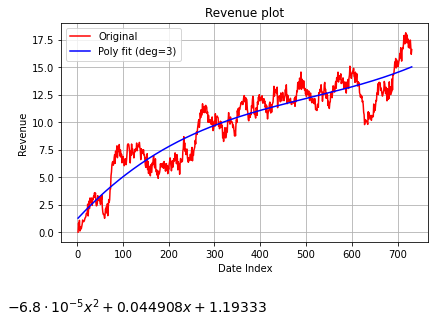

In [13]:
# visualize raw revenue data
fig, ax = plt.subplots()
ax.plot(x, y, "r", label='Original')
ax.plot(x,f(x),"b", label='Poly fit (deg=' + str(n_deg) + ')')
plt.xlabel("Date Index")
plt.ylabel("Revenue")
title = 'Revenue plot'
plt.legend()
plt.grid()
plt.title(title)
plt.gcf().text(0, -.1, "${}$".format(eq_latex), fontsize=14)
plt.tight_layout()
save_fig(title) 

### revenue plot with rolling mean & std deviation

Saving figure Rolling Mean & Standard Deviation


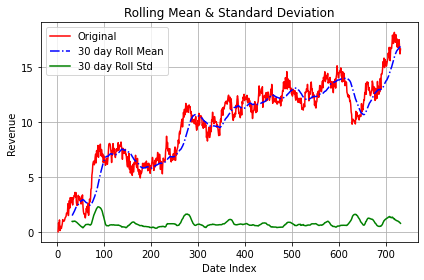

In [14]:
# plot rolling mean and rolling standard
x = np.array(df.index.values)
fig, ax = plt.subplots()
ax.plot(x, df['Revenue'], "r", label='Original')
ax.plot(x,df['rolling_mean'], "b-.", label=str(n_days) + ' day Roll Mean')
ax.plot(x,df['rolling_std'], "g", label=str(n_days) + ' day Roll Std')
plt.xlabel("Date Index")
plt.ylabel("Revenue")
title = 'Rolling Mean & Standard Deviation'
plt.locator_params(axis="both", 
      integer=True, tight=False)
plt.legend()
plt.grid()
plt.title(title)
save_fig(title) 

Generally, trending up and not stationary. Also, does not appear to have seasonality.

adapted from:
https://www.youtube.com/watch?v=o7Ux5jKEbcw
Michael Grogan

In [15]:
# do this for stock prices, but not for revenue...
revenue = rev['Revenue'].values
lnrevenue = np.log(revenue)
plt.plot(lnrevenue)
plt.show()

NameError: name 'rev' is not defined

Although, for time periods from 100+, the data appears to be "stationary"...

## Autocorrelation

### python only

In [ ]:
# autocorrelation python only
# adapted from https://scicoding.com/4-ways-of-calculating-autocorrelation-in-python/
data = revenue.tolist()
n_lags = 25
acorr = []
mean = sum(data) / len(data)  # mean
var = sum([(x - mean)**2 for x in data]) / len(data) 
ndata = [x - mean for x in data]
for l in range(1,n_lags):
    c = 1 # Self correlation
    if (l > 0):
        tmp = [ndata[l:][i] * ndata[:-l][i] 
               for i in range(len(data) - l)]
        c = sum(tmp) / len(data) / var
    acorr.append(c)
print(np.around(acorr, 3).tolist()) # print out list

### statsmodels library

In [ ]:
# autocorrelation using statsmodels
# adapted from https://scicoding.com/4-ways-of-calculating-autocorrelation-in-python/
n_lags = 25
data = revenue.tolist()
import statsmodels.api as sm
acorr = sm.tsa.acf(data, nlags = (n_lags)-1)
print(np.around(acorr, 3).tolist()) # print out list

### numpy.correlate

In [ ]:
# autocorrelation using numpy
# adapted from https://scicoding.com/4-ways-of-calculating-autocorrelation-in-python/
import numpy
n_lags = 25
data = revenue.tolist()
x = np.array(data) 
mean = numpy.mean(data)
var = numpy.var(data)
ndata = data - mean
acorr = numpy.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
acorr = acorr / var / len(ndata)
print(np.around(acorr, 3).tolist()[:n_lags]) # print out list

### numpy & fourier transform

In [ ]:
import numpy
n_lags = 25
data = revenue.tolist()
# Nearest size with power of 2
size = 2 ** numpy.ceil(numpy.log2(2*len(data) - 1)).astype('int')
var = numpy.var(data) # variance
ndata = data - numpy.mean(data) # normalize data
fft = numpy.fft.fft(ndata, size) # calculate fft
pwr = np.abs(fft) ** 2 # get power spectrum

# Calculate the autocorrelation from inverse FFT of the power spectrum
acorr = numpy.fft.ifft(pwr).real / var / len(data)
print(np.around(acorr, 3).tolist()[:n_lags]) # print out list

### Plot Autocorrelation

In [ ]:
# autocorrelation
acf_1 = acf(lnrevenue)
test_df = pd.DataFrame([acf_1]).T
test_df.columns = ['Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
plt.xlabel("Lag")
plt.ylabel("Correlation")
title = 'Autocorrelation'
plt.legend()
plt.title(title)
save_fig(title)

The autocorrelation is a steady decrease downward...

In [ ]:
# partial autocorrelation
pacf_1 = pacf(lnrevenue)
test_df = pd.DataFrame([pacf_1]).T
test_df.columns = ['Partial Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')
plt.xlabel("Lag")
plt.ylabel("Correlation")
title = 'Partial Autocorrelation'
plt.legend()
plt.title(title)
save_fig(title)

The partial autocorrelation is a sudden drop. Combined with the steady decrease of the autocorrelation indicates that there is an "stationary" AR1 process of the time series data which is the way we want the time-series to be structured.

### augmented dickey-fuller

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
https://machinelearningmastery.com/time-series-data-stationary-python/ 

In [ ]:
# augmented dickey-fuller - test for stationary data
result = ts.adfuller(df['Revenue'].values, 1)
print('Data: df (raw, non-stationary)')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
# code adapted from (Elleh, 2022)
# H0: Non-stationary
# H1: Stationary
if result[1]<=0.05:
    print('Reject null, series is stationary.')
else:
    print('Fail to reject null, series is non-stationary.')

## make data stationary

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html

In [ ]:
"""Calculates difference of Dataframe element compared with another 
element in the Dataframe (default is element in previous row)."""
df_stationary = df.diff(periods=1,axis=0).dropna()
print(df_stationary.info())
print(df_stationary.shape)
#print(df_stationary.describe())

In [ ]:
# augmented dicky-fuller AR1 - test for stationary data
result = ts.adfuller(df_stationary['Revenue'].values,1)
print('Data: df_stationary (differenced)')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
# code adapted from (Elleh, 2022)
# H0: Non-stationary
# H1: Stationary
if result[1]<=0.05:
    print('Reject null, series is stationary.')
else:
    print('Fail to reject null, series is non-stationary.')

## export stationary data

In [ ]:
# export stationary data to file
df_stationary.to_csv('tables\stationary.csv', index=True, header=True)
print(df_stationary.info())
print(df_stationary.shape)
print(df_stationary.iloc[::100, :])

## train test split

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
#setup training and test data 80/20
test_size = int(.20 * df_stationary.shape[0])  # last 20%
train, test = train_test_split(df, test_size=test_size, shuffle=False)
print('training: {}'.format(train.shape))
print('testing: {}'.format(test.shape))

## decompose data

In [ ]:
# decompose revenue data - additive
# adapted from https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_stationary['Revenue'].values, 
            model='additive', period=1)
result.plot()
plt.show()

## define & train model(s)

### arima_v1

In [ ]:
# run model and predict
X_train = np.array(train['Revenue'])
model = ARIMA(X_train, order=(0,1,0))
arima_v1 = model.fit()
print(arima_v1.summary())

## plot predictions

In [ ]:
# predict next 9 time step values
n_predictions = 9; last_time = 730
predictions = arima_v1.predict(700,710, type='levels')
predictions

In [ ]:
x = range(len(predictions))
fig, ax = plt.subplots()
ax.plot(x, predictions, "b", label='Predictions')
plt.xlabel("Date Index")
plt.ylabel("Revenue")
title = 'Predictions'
plt.locator_params(axis="both", 
      integer=True, tight=False)
plt.legend()
plt.grid()
plt.title(title)
save_fig(title) 